In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


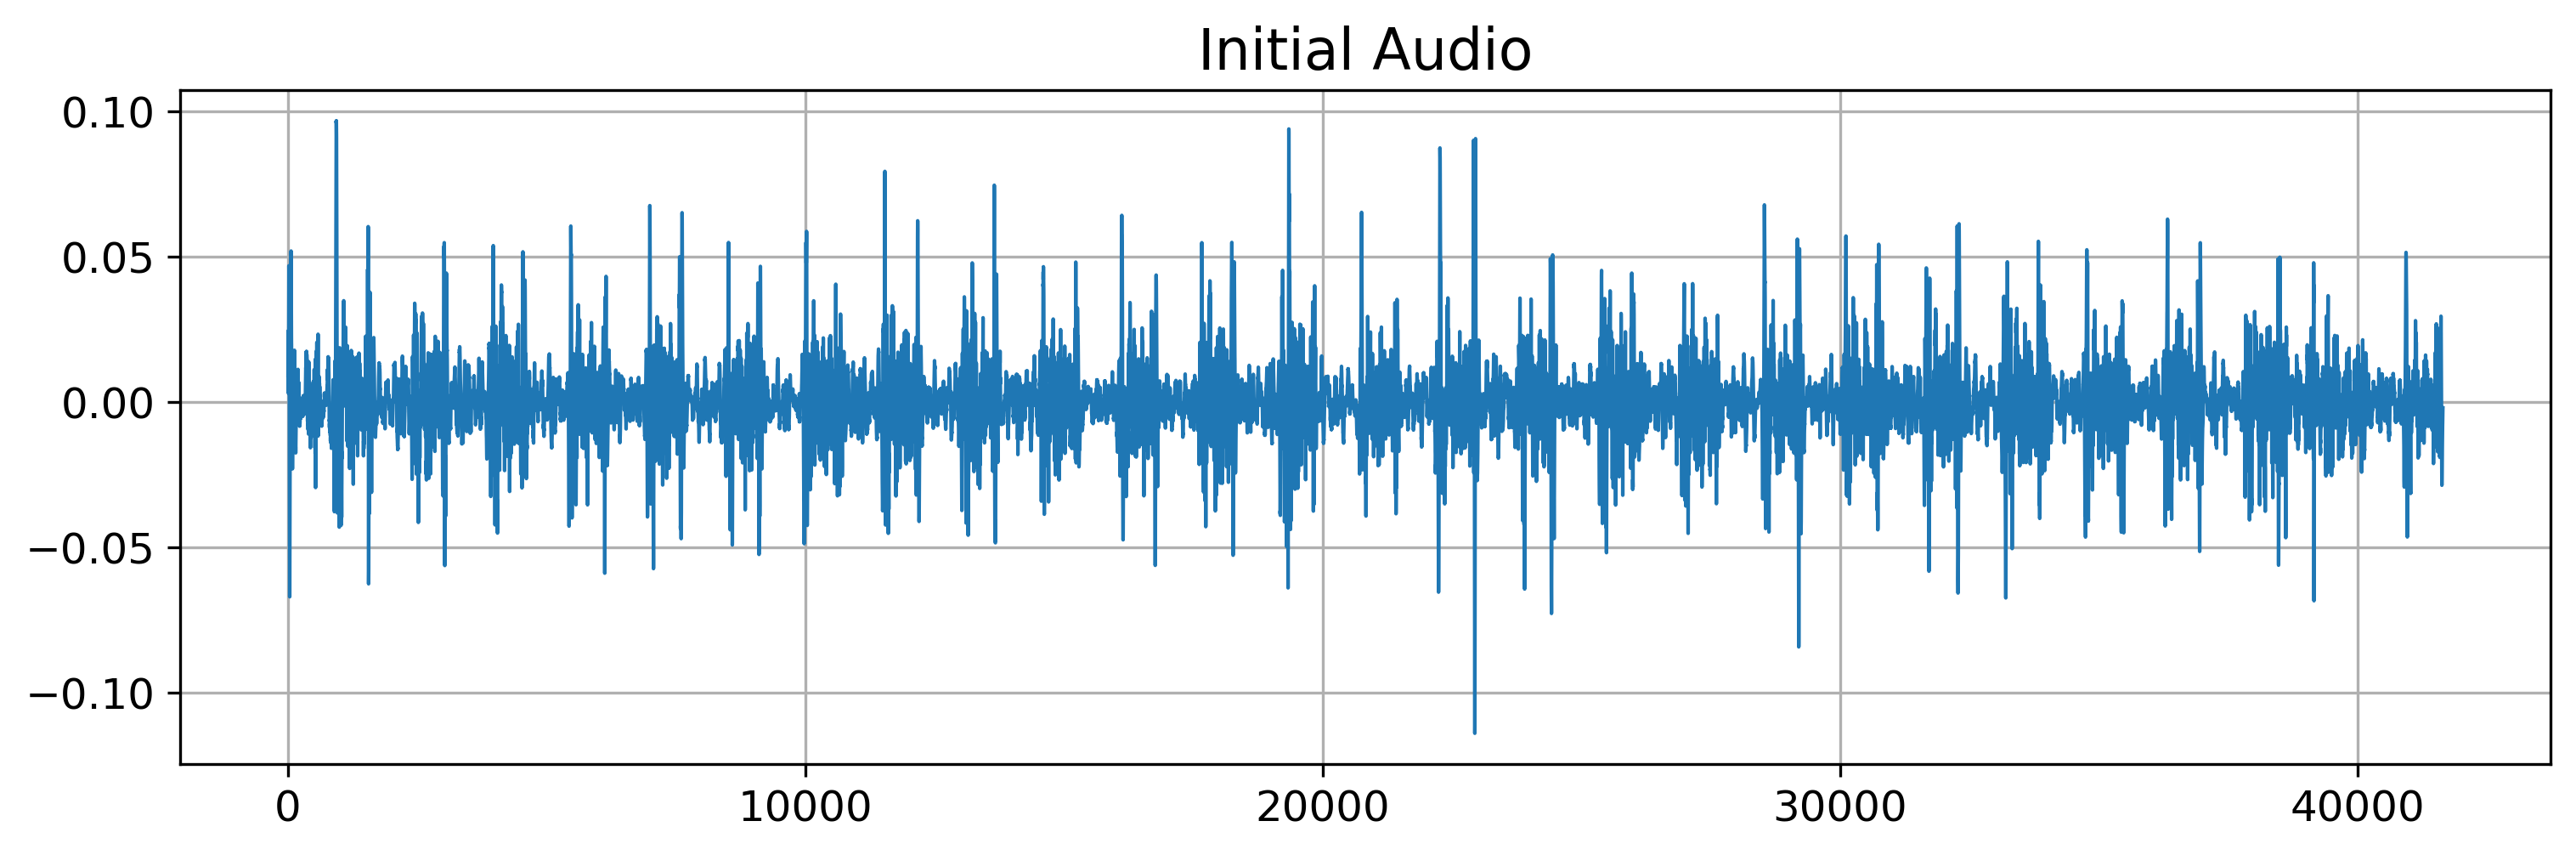

In [ ]:
import librosa
import matplotlib.pyplot as plt


def plot_signal(audio_data, title=None):
    plt.figure(figsize=(12, 3.5), dpi=300)
    plt.plot(audio_data, linewidth=1)
    plt.title(title,fontsize = 16)
    plt.tick_params(labelsize=12)
    plt.grid()
    plt.show()

audio_path = 'test.wav' #auido loading
audio_data, fs = librosa.load(audio_path, sr=None)
plot_signal(audio_data, title='Initial Audio')

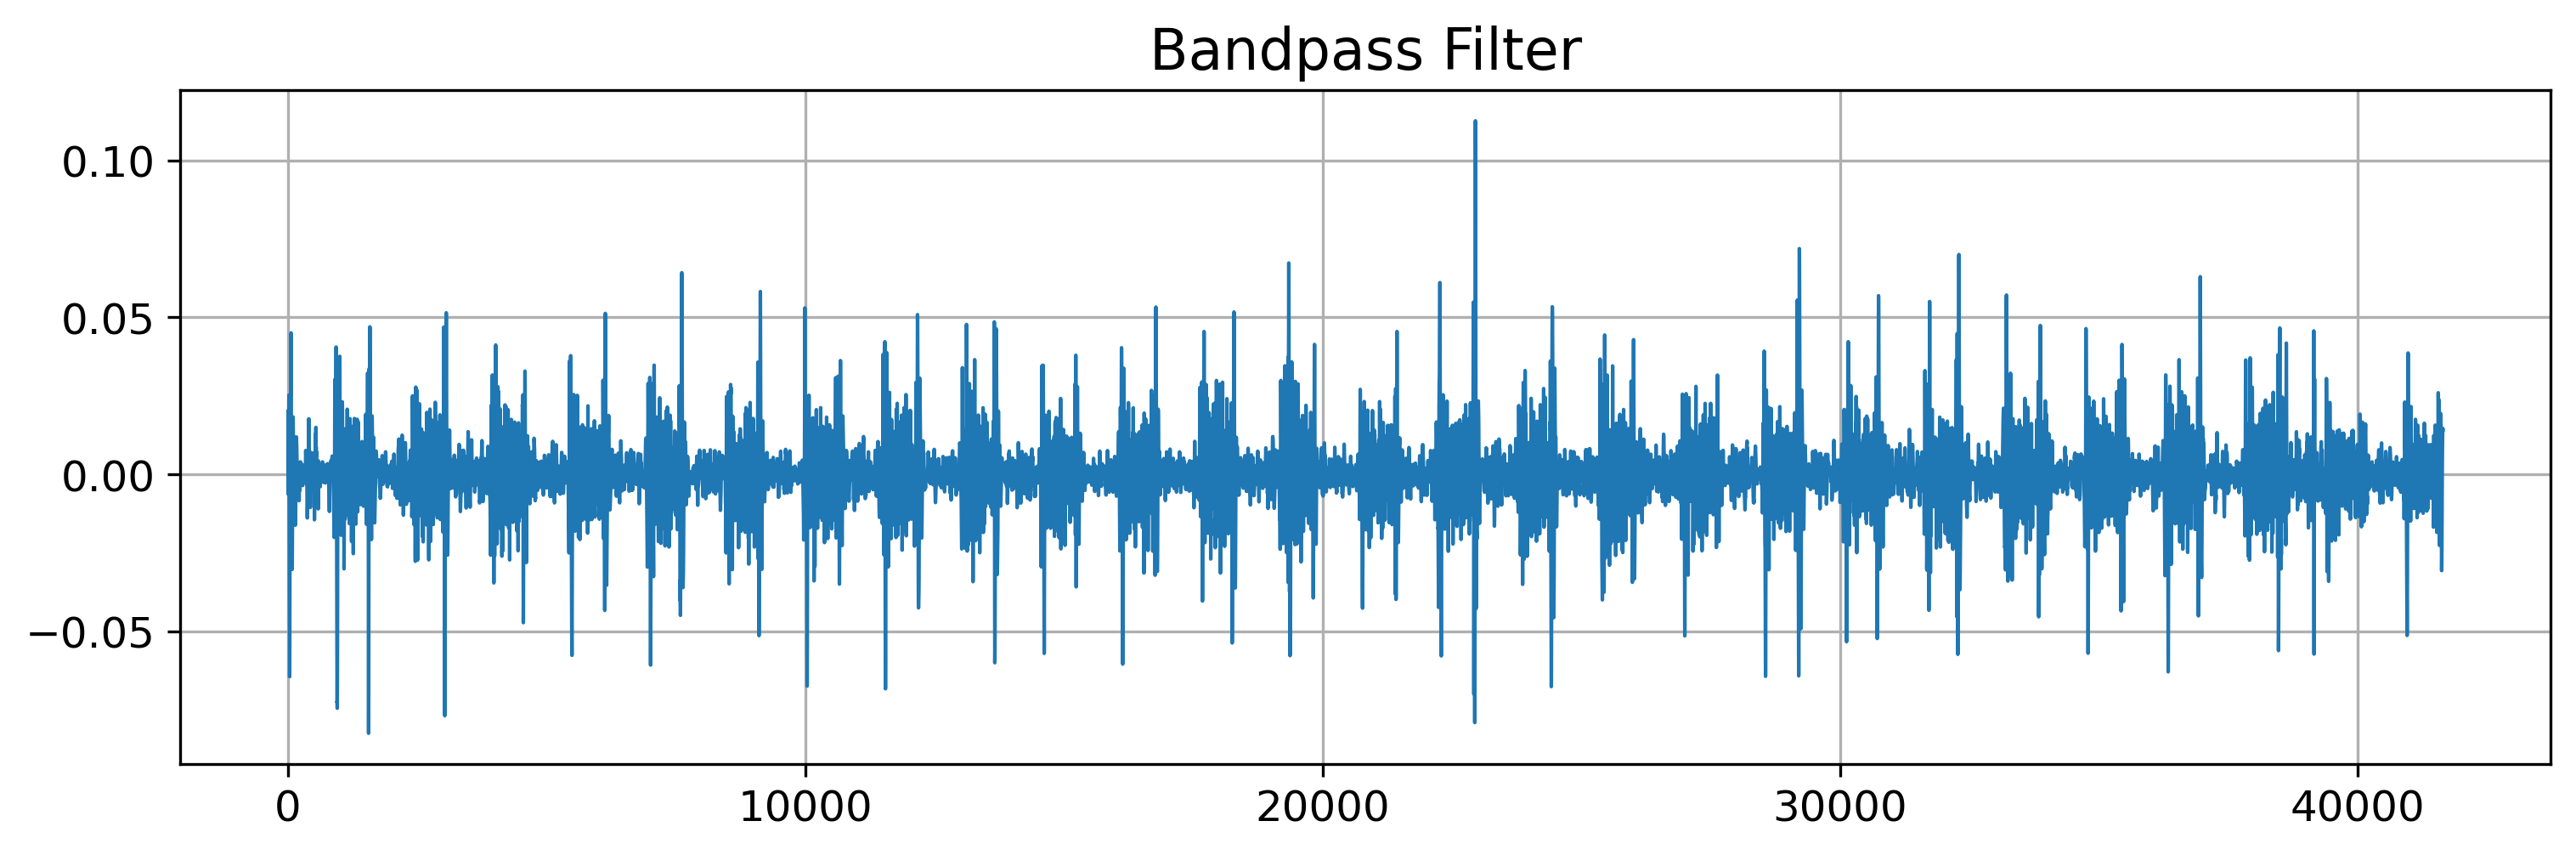

In [ ]:
from scipy import signal


def band_pass_filter(original_signal, order, fc1,fc2, fs):

    b, a = signal.butter(N=order, Wn=[2*fc1/fs,2*fc2/fs], btype='bandpass')
    new_signal = signal.lfilter(b, a, original_signal)
    return new_signal


audio_data = band_pass_filter(audio_data, 2, 25, 400, fs)#buterworth bandpass filter
plot_signal(audio_data, title='Bandpass Filter')

In [ ]:
pip install samplerate

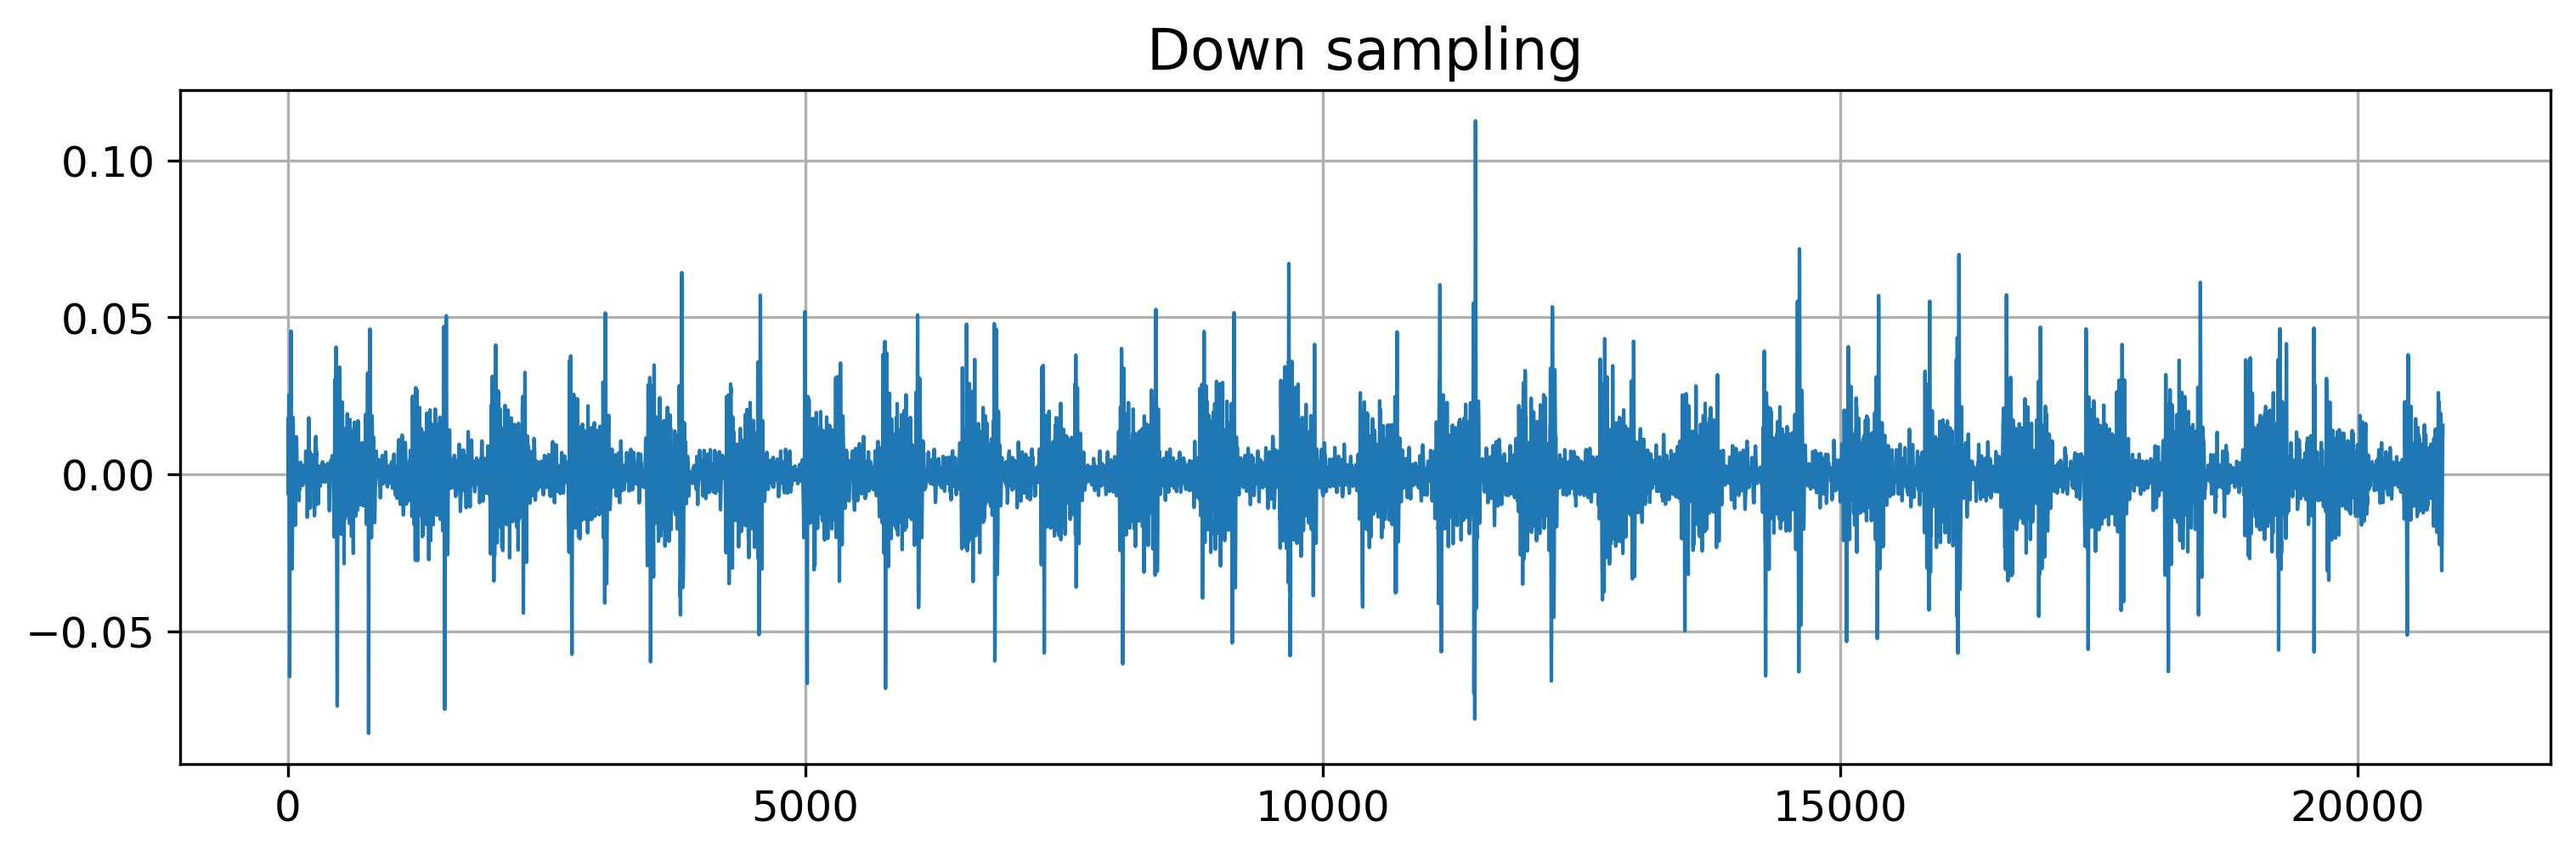

In [ ]:
import samplerate

down_sample_audio_data = samplerate.resample(audio_data.T, 1000 / fs, converter_type='sinc_best').T #down sampling
plot_signal(down_sample_audio_data, title='Down sampling')

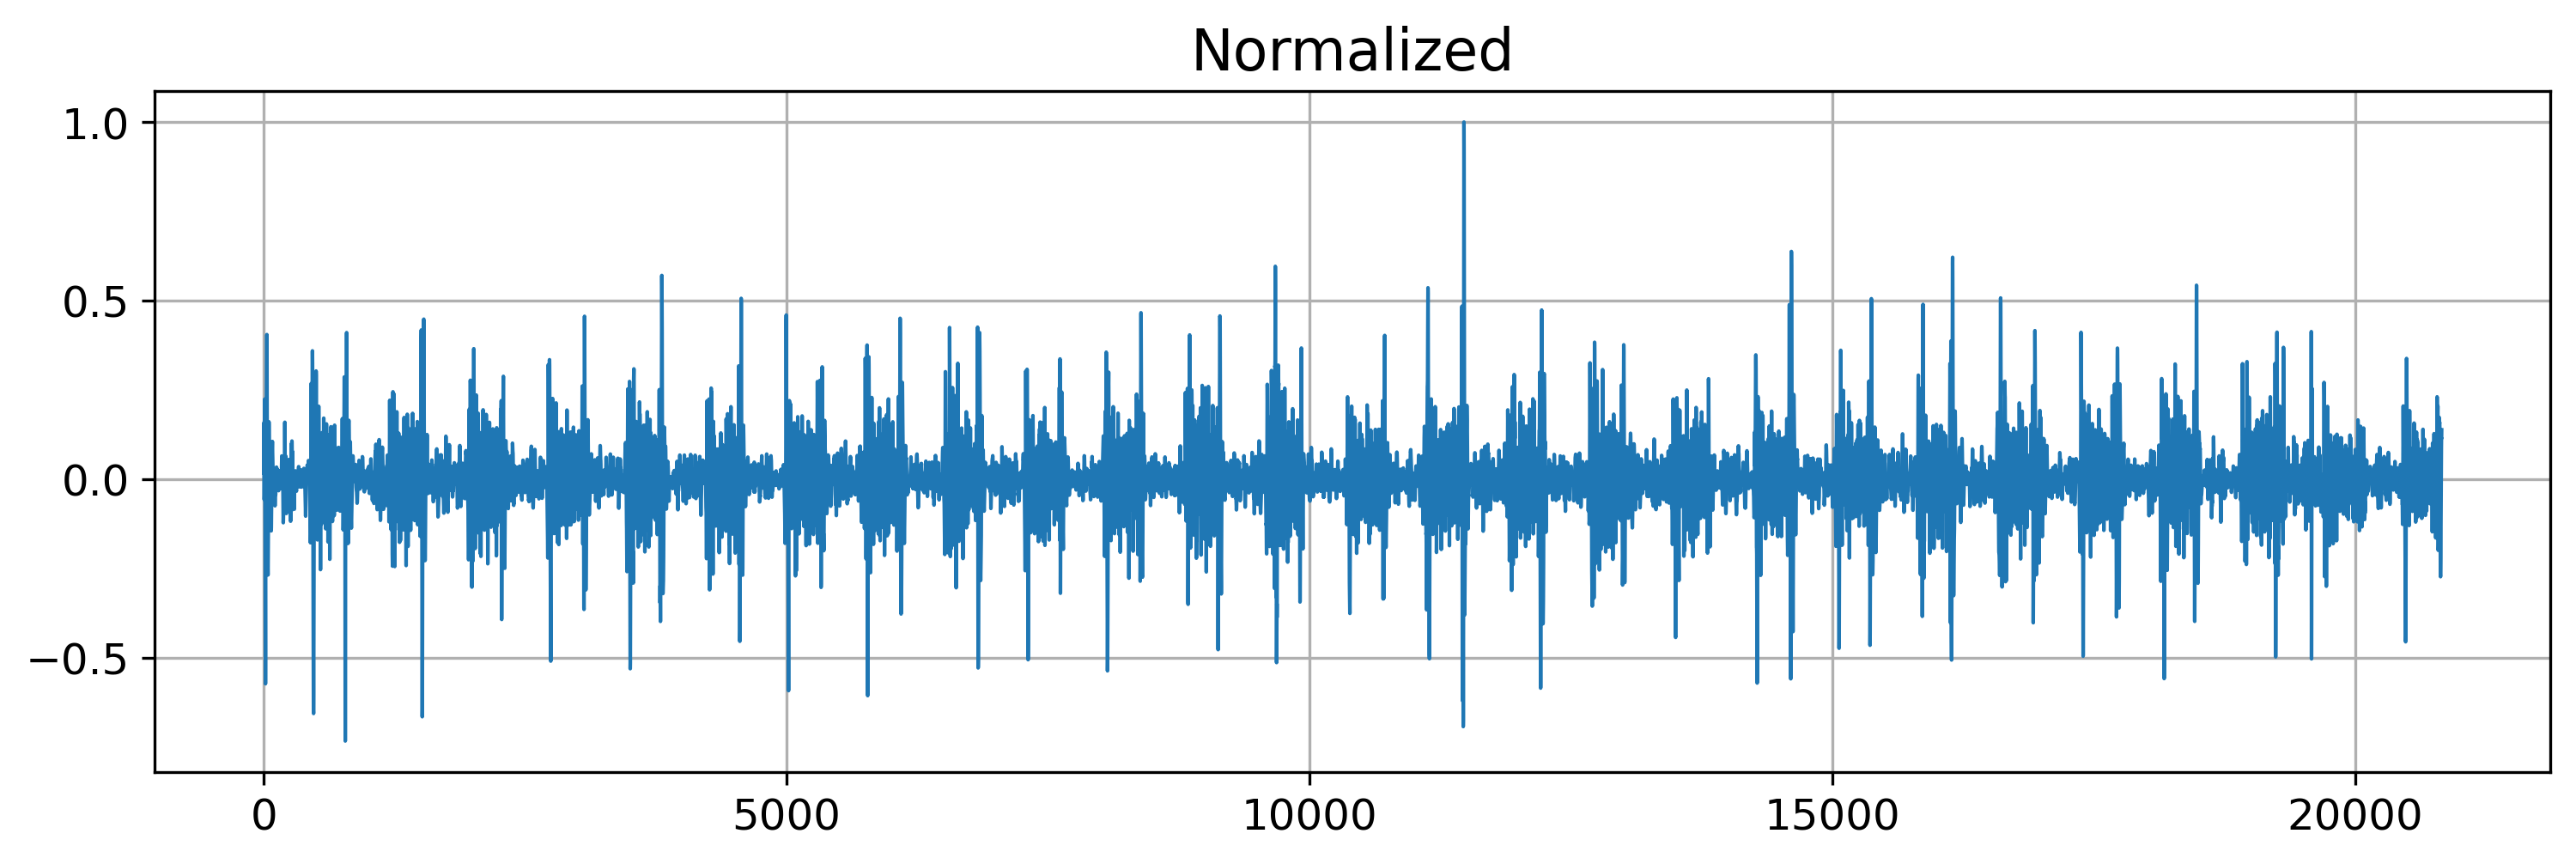

In [ ]:
import numpy as np
down_sample_audio_data = down_sample_audio_data / np.max(np.abs(down_sample_audio_data))#normalized
plot_signal(down_sample_audio_data, title='Normalized')

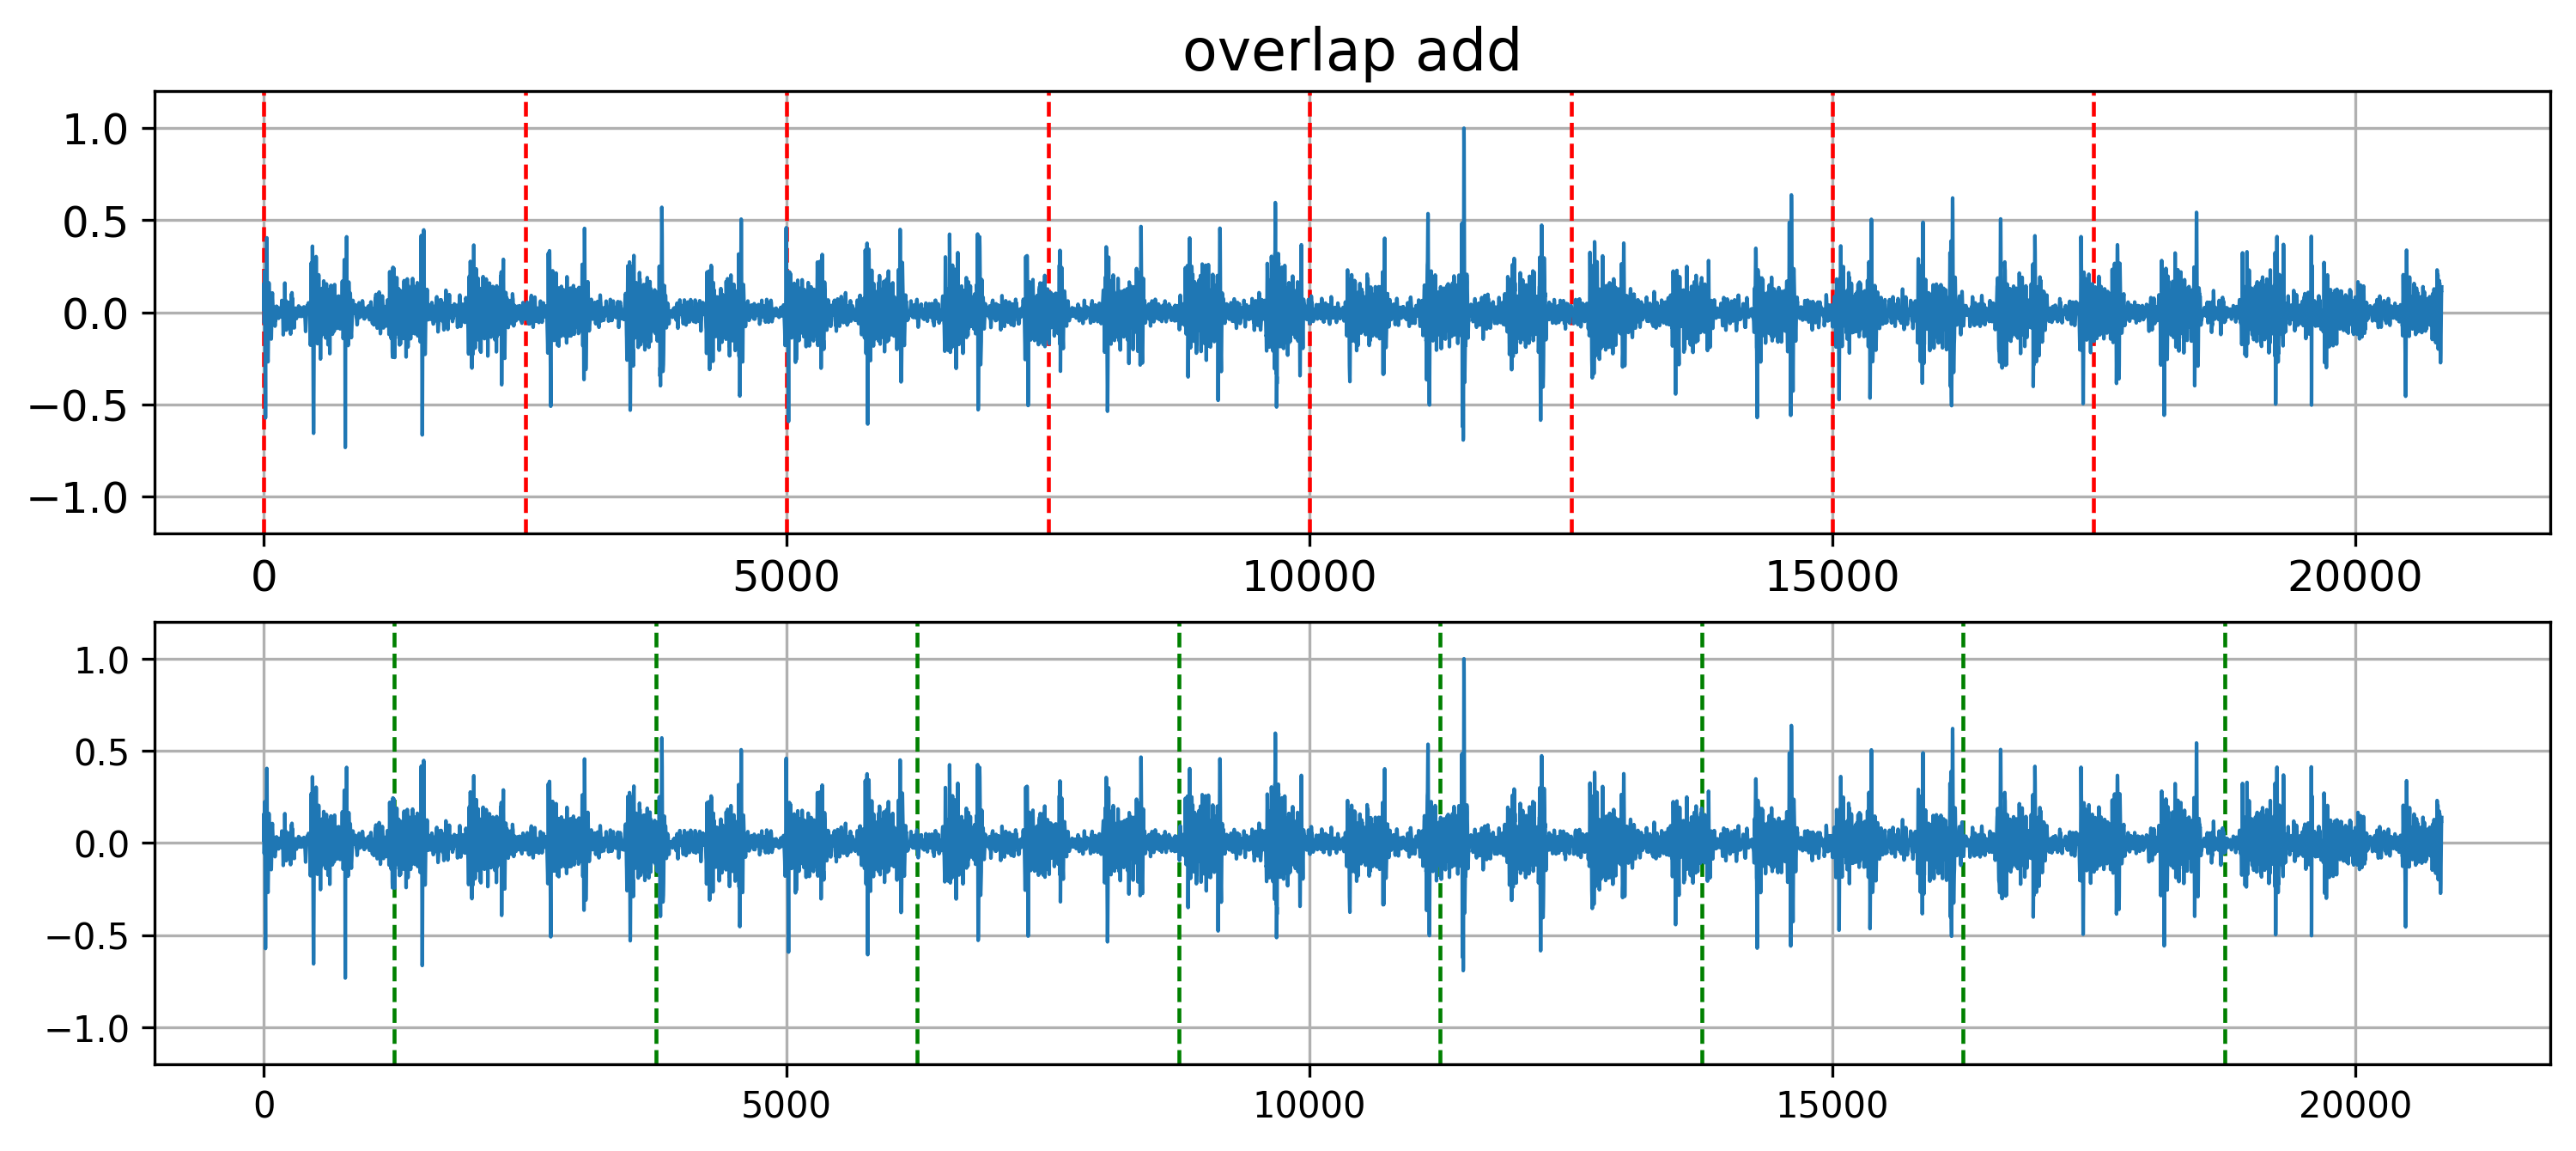

In [ ]:
total_num = len(down_sample_audio_data)/(2500)#cut
fig = plt.figure(figsize=(12, 5), dpi=300)

ax1 = fig.add_subplot(2,1,1)
plt.plot(down_sample_audio_data,linewidth=1)
plt.title('overlap add',fontsize=16)
plt.tick_params(labelsize=12)
plt.ylim([-1.2,1.2])
plt.grid()
for j in range(int(total_num)):
    plt.vlines(j*2500, -1.2, 1.2, color="red",linestyle='--',linewidth=1.1)

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(down_sample_audio_data, linewidth=1)
for j in range(int(total_num)):
    plt.vlines(j*2500 + 1250, -1.2, 1.2, color="green",linestyle='--',linewidth=1.1)
plt.ylim([-1.2,1.2])
plt.grid()
plt.show()

In [ ]:
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram

def polycoherence(data, *args, dim=2, **kwargs):

    N = len(data)
    kwargs.setdefault('nperseg', N // 20)
    kwargs.setdefault('nfft', next_fast_len(N // 10))
    if dim == 0:
        f = _polycoherence_0d
    elif dim == 1:
        f = _polycoherence_1d
    elif dim == 'sum':
        f = _polycoherence_1d_sum
    elif dim == 2:
        f = _polycoherence_2d
    else:
        raise
    return f(data, *args, **kwargs)

def plot_polycoherence(freq1, freq2, bicoh):
    df1 = freq1[1] - freq1[0]
    df2 = freq2[1] - freq2[0]
    freq1 = np.append(freq1, freq1[-1] + df1) - 0.5 * df1
    freq2 = np.append(freq2, freq2[-1] + df2) - 0.5 * df2
    plt.figure(figsize=(4,4),dpi=300)
    # fig, ax = plt.subplots()
    plt.pcolormesh(freq2, freq1, np.abs(bicoh),cmap=plt.cm.jet)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    plt.figure(figsize=(4,4),dpi=300)
    ax = plt.subplot(1, 1, 1)
    plt.contour(freq2[:-1], freq1[:-1], np.abs(bicoh),10,linewidths=1,cmap=plt.cm.jet)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def _polycoherence_2d(data, fs, *ofreqs, norm=2, flim1=None, flim2=None,
                      synthetic=(), **kwargs):
    """
    Polycoherence between freqs and their sum as a function of f1 and f2
    """
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.require(spec, 'complex64')
    spec = np.transpose(spec, [1, 0])  # transpose (f, t) -> (t, f)
    if flim1 is None:
        flim1 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    if flim2 is None:
        flim2 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    ind1 = np.arange(*np.searchsorted(freq, flim1))
    ind2 = np.arange(*np.searchsorted(freq, flim2))
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None, None]
    sumind = ind1[:, None] + ind2[None, :] + sum(ind3)
    temp = spec[:, ind1, None] * spec[:, None, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** norm1, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    del temp
    if norm is not None:
        coh = np.abs(coh, out=coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], freq[ind2], coh

def __get_norm(norm):
    if norm == 0 or norm is None:
        return None, None
    else:
        try:
            norm1, norm2 = norm
        except TypeError:
            norm1 = norm2 = norm
        return norm1, norm2

def __freq_ind(freq, f0):
    try:
        return [np.argmin(np.abs(freq - f)) for f in f0]
    except TypeError:
        return np.argmin(np.abs(freq - f0))

def __product_other_freqs(spec, indices, synthetic=(), t=None):
    p1 = np.prod([amplitude * np.exp(2j * np.pi * freq * t + phase)
                  for (freq, amplitude, phase) in synthetic], axis=0)
    p2 = np.prod(spec[:, indices[len(synthetic):]], axis=1)
    return p1 * p2

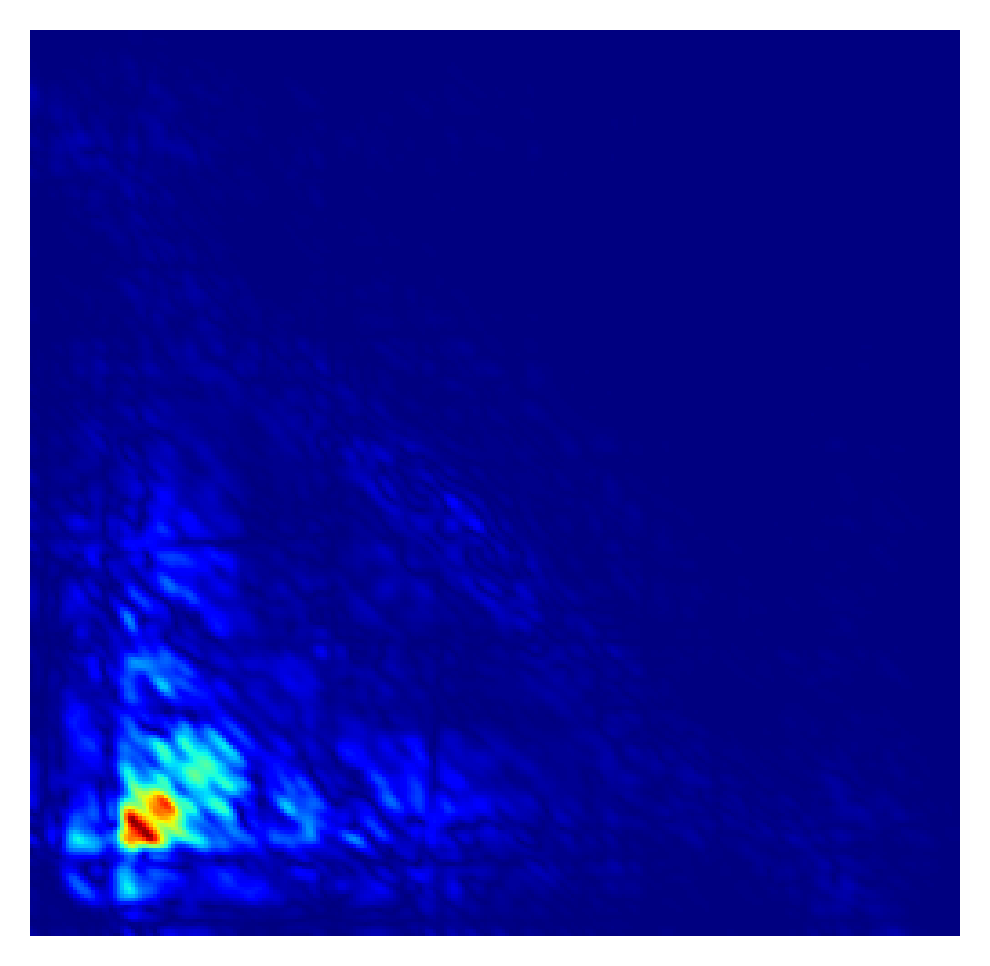

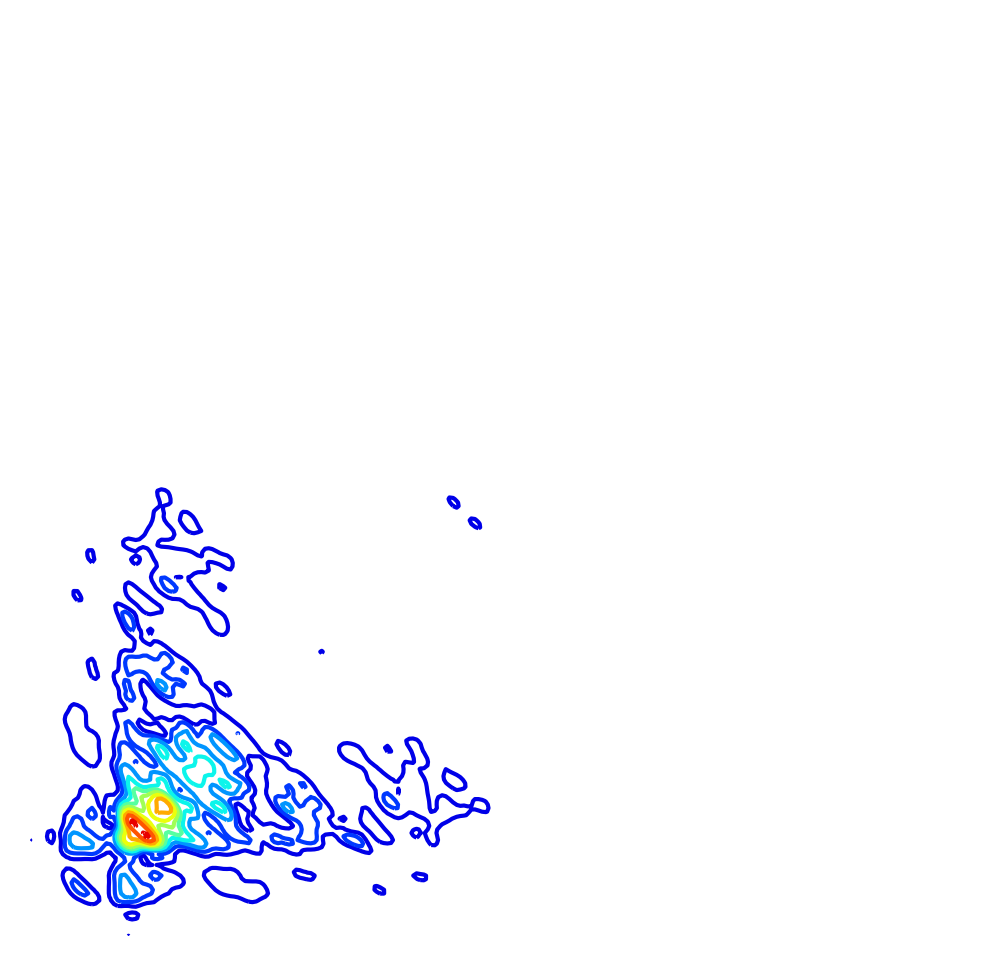

In [ ]:
ex_audio_data = down_sample_audio_data[:2500]
freq1, freq2, bi_spectrum = polycoherence(
       ex_audio_data, 
       nfft=1024, 
       nperseg=256, 
       noverlap = 100, 
       fs = 1000,
       norm=None)
bi_spectrum = np.array(abs(bi_spectrum))  # calculate bi_spectrum
bi_spectrum = 255 * (bi_spectrum - np.min(bi_spectrum)) / (np.max(bi_spectrum) - np.min(bi_spectrum))
plot_polycoherence(freq1, freq2, bi_spectrum)
bi_spectrum = bi_spectrum.reshape((256, 256, 1))